### Import packages & initialization

In [1]:
import sys
import torch
import glob
import numpy as np
import re
import logging
import os
from google.colab import drive
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive')

Mounted at /content/drive


In [2]:
!pip3 install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [3]:
def set_paths(drive_path) :

    image_paths = sorted(glob.glob(drive_path + "data/*.tiff"))
    label_paths = sorted(glob.glob(drive_path + "labels/*.tif"))
    dir_img = drive_path + 'data/'
    dir_mask = drive_path + 'labels/'
    dir_checkpoint = Path('./checkpoints/')
    print("Total Observations:\t", 'images', len(image_paths), ', labels', len(label_paths))

    return image_paths, label_paths, dir_img, dir_mask, dir_checkpoint

drive_path =  'drive/MyDrive/Deep_Learning_Project_28/training_dataset/'
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)
print("Total Observations:\t", 'images', len(image_paths), ', labels', len(label_paths))

## Working Around

### Get Pixels

In [ ]:
def get_pixels(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    np_array = np.array(image, dtype=np.float32)

    # Convert the NumPy array to a PyTorch tensor
    tensor_image = torch.from_numpy(np_array)

    # Flatten the tensor to get the pixel values
    flattened_pixels = tensor_image.view(-1)

    return flattened_pixels

In [ ]:
image_path = drive_path + "data/001.tiff" # original dataset

pixels = get_pixels(image_path)

# Print the pixel values
print(min(pixels),torch.mean(pixels),max(pixels))

tensor(18465.) tensor(32907.8359) tensor(44477.)


### Example of a Noisy Image

In [ ]:
def add_gaussian_noise(image, mean=0, std=25):
    """
    Add Gaussian noise to the given image.

    Parameters:
    - image: Input image (PIL Image or NumPy array).
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Image with added Gaussian noise.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Generate Gaussian noise
    noise = np.random.normal(mean, std, image.shape)

    # Add noise to the image
    noisy_image = image + noise

    # Clip pixel values to the valid 16-bit range [0, 65535]
    noisy_image = np.clip(noisy_image, 0, 65535)

    # Convert back to uint8 if necessary
    if noisy_image.dtype == np.float32:
        noisy_image = noisy_image.astype(np.uint8)

    if isinstance(image, Image.Image):
        return Image.fromarray(noisy_image)
    else:
        return noisy_image

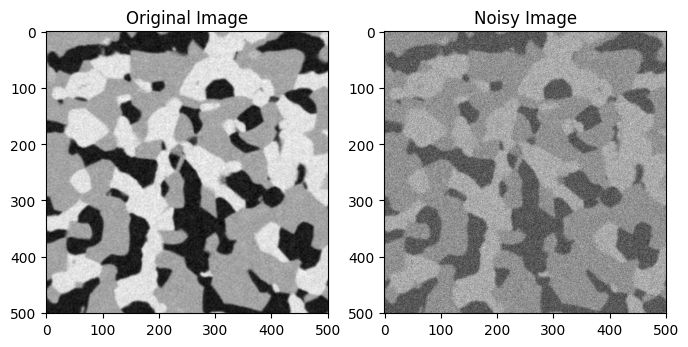

In [10]:
std = 5000

#image_path = drive_path + "data/SOCprist0081.tiff"
image_path = drive_path + "data/081.tiff"
original_image = Image.open(image_path)

# Add Gaussian noise
noisy_image = add_gaussian_noise(original_image, mean=0, std=std)

# Display original and noisy images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')


# Save the figure
plt.savefig(drive_path+'original_and_noisy_images_compare.png')

plt.show()

# Convert the image to a NumPy array
np_array = np.array(noisy_image, dtype=np.float32)

# Convert the NumPy array to a PyTorch tensor
tensor_image = torch.from_numpy(np_array)

# Flatten the tensor to get the pixel values
flattened_pixels = tensor_image.view(-1)

## Noisy Images

### Add Noisy Images

In [ ]:
def add_noisy_images(drive_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/',n=100,std=5000): 

    input_folder_path = drive_path + "data/"
    input_folder_labels_path = drive_path + "labels/"
    # List all files in the input directory
    file_list = os.listdir(input_folder_path)

    # Randomly select n images
    selected_files = np.random.choice(file_list, n, replace=False)

    # Iterate through the selected files and add Gaussian noise

    image_num = 501

    for file_name in selected_files:
        if file_name.endswith(".tiff") or file_name.endswith(".tif"):

            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder_path, file_name)

            # Open the original image
            original_image = Image.open(input_image_path)

            # Add Gaussian noise
            noisy_image = add_gaussian_noise(original_image, mean=0, std=std)

            # Convert the NumPy array back to a PIL Image
            noisy_image_pil = Image.fromarray(noisy_image)

            # Construct the full path to the output image
            noisy_data_name = "SOCprist0"+ str(image_num)+".tiff"
            output_image_path = os.path.join(input_folder_path,noisy_data_name)


            # Save the noisy image
            noisy_image_pil.save(output_image_path)

            # Add labels to label folder
            original_label_path = input_folder_labels_path+ 'slice__'+file_name[-8:-5]+'.tif'
            noisy_label_name = 'slice__'+str(image_num)+'.tif'
            noisy_label_path = os.path.join(input_folder_labels_path, noisy_label_name)

            # Copy the original label file to the new label file
            copyfile(original_label_path, noisy_label_path)


            image_num = image_num + 1

    print(f"Noisy images saved to {input_folder_path}")



def add_prefix_to_files(drive_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/' , prefix ="slice__"):
    """
    Add a prefix to the beginning of all files in the specified folder.

    Parameters:
    - folder_path: Path to the folder containing the files.
    - prefix: The prefix to add to each filename.
    """

    folder_path =drive_path + "labels/"
    # List all files in the folder
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)

        # Construct the new filename with the added prefix
        new_file_name = prefix + file_name

        # Construct the full path to the new file
        new_file_path = os.path.join(folder_path, new_file_name)

        # Rename the file with the new filename
        os.rename(file_path, new_file_path)

In [ ]:
add_noisy_images(drive_path = drive_path,n=100,std=5000)

Noisy images saved to drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/


# Dataset loading utils

(https://github.com/milesial/Pytorch-UNet/blob/master/utils/data_loading.py)

In [ ]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = load_image(mask_file[0])
        img = load_image(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)
        mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, images_dir, mask_dir, scale=1):
        super().__init__(images_dir, mask_dir, scale, mask_suffix='_mask')

## Change to adapt the dataset to the loading utils

Rename images and labels so they are compatible with BasicDataset.

The Carvana dataset has image, mask pairs of image:0cdf5b5d0ce1_11, mask:0cdf5b5d0ce1_11_mask (https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview).

Our dataset has image, mask pairs of image: SOCprist0025, label: slice_025.

We rename all files and keep only the ids (e.g. 025)

In [ ]:
from os.path import splitext, isfile, join

# Images
def rename_images(image_paths,drive_path ):
    for index, path in enumerate(image_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "data/" + id + ".tiff")
        os.rename(path, drive_path + "data/" + id + ".tiff")

# Labels
def rename_labels(label_paths,drive_path ):
    for index, path in enumerate(label_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "labels/" + id + ".tif")
        os.rename(path, drive_path + "labels/" + id + ".tif")

In [ ]:
rename_images(image_paths = image_paths,drive_path = drive_path)
rename_labels(label_paths = label_paths,drive_path =drive_path)

# Dice loss

In [ ]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

# Evaluation

Using multiclass dice score

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# from utils.dice_score import multiclass_dice_coeff, dice_coeff


@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

# Training


Installing wandb to track our training and results.

In [ ]:
!pip3 install wandb

In [ ]:
import wandb
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

def train_model(
        model,
        device,
        dir_img, 
        dir_mask,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 1,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
        val_original_percent = 0.5,
        num_train_records = 50,
        split_type = 'random_split'
):
    # 1. Create dataset
    try:
        # dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions

    if split_type == 'random_split':
        n_val = int(len(dataset) * val_percent)
        n_train = len(dataset) - n_val
        train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
      

    elif split_type == 'split_noisy_after_training':
        train_set, val_set = split_noisy_after_training(dataset, val_percent=val_percent, noisy_indices=100, val_original_percent=val_original_percent, seed=0)
    
    
    elif split_type == 'split_number_training':
        train_set, val_set = split_number_training(dataset, num_train_records)
      

    n_val = len(val_set)
    n_train = len(train_set)

    print('Number of training rows:',n_train)
    print('Number of validation rows:',n_val)


    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    #wandb.login(key="fb60e2d788769eea516be5f8a1aa344a4582d208")
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() # if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        # Added validation loss to the log //Julius
                        model.eval()
                        val_loss = 0

                        with torch.no_grad():
                          for val_batch in val_loader:
                              val_images, val_true_masks = val_batch['image'], val_batch['mask']
                              val_images = val_images.to(device=device, dtype=torch.float32)
                              val_true_masks = val_true_masks.to(device=device, dtype=torch.long)

                              # Forward pass for validation
                              val_masks_pred = model(val_images)

                              # Compute validation loss
                              batch_loss = criterion(val_masks_pred, val_true_masks)
                              val_loss += batch_loss.item()

                        # Average the validation loss
                        avg_val_loss = val_loss / len(val_loader)

                        # Leftover from earlier attempt at validation loss calculation in evaluate()
                        # Note to self: Remove //Julius
                        val_score = evaluate(model, val_loader, device, criterion, amp)[0]
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation loss': avg_val_loss,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()

def split_noisy_after_training(dataset, val_percent=0.2, noisy_indices=100, val_original_percent=0.5 , seed=0):



    # Create a new dataset excluding the last 100 indices

    original_indices = list(range(len(dataset) - noisy_indices))
    dataset_original = Subset(dataset, original_indices)

    noisy_indices = list(range(len(dataset)-noisy_indices , len(dataset)))
    dataset_noisy    = Subset(dataset, noisy_indices)


    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_val_original = int(n_val * val_original_percent)
    n_val_noisy    =  n_val - n_val_original
    n_train = len(dataset_original) - n_val_original

    train_set, val_set_original = random_split(dataset_original, [n_train, n_val_original], generator=torch.Generator().manual_seed(0))

    # 3. Randomly select n_val_noisy samples from the noisy dataset
    indices_noisy = np.random.choice(len(dataset_noisy), size=n_val_noisy, replace=False)
    val_set_noisy = [dataset_noisy[i] for i in indices_noisy]

    # 4. Combine the original validation set and the noisy validation set
    val_set = val_set_original + val_set_noisy

    return train_set, val_set


def split_number_training(dataset, num_train_records, seed=0):
    """
    Split a dataset into training and validation sets.

    Parameters:
        dataset (Dataset): The original dataset.
        num_train_records (int): The number of records to include in the training set.
        seed (int): Seed for reproducibility.

    Returns:
        tuple: A tuple containing the training set and validation set.
    """
    total_records = len(dataset)
    num_val_records = total_records - num_train_records

    # Generate indices for random split
    indices = list(range(total_records))
    np.random.seed(seed)
    np.random.shuffle(indices)

    # Split into training and validation sets
    train_indices = indices[:num_train_records]
    val_indices = indices[num_train_records:]

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)

    return train_set, val_set


## Change in args

Bypass `get_args()` by populating the args object manually with values that are relevant to our application.

In [ ]:
class ArgsBypass:
  epochs  = 5
  batch_size  = 1
  lr = 1e-5
  load = False
  scale = 1
  val = 10.0
  amp = False
  bilinear = False
  classes = 3
  pass

args = ArgsBypass()

Please use the wandb run link logged at the beginning of training to track the progress of the run.

In [ ]:
args = ArgsBypass()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
# model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = UNet(n_channels=1, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
              f'\t{model.n_channels} input channels\n'
              f'\t{model.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent=0.5,
        num_train_records = 50,
        split_type = 'random_split'
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                  'Enabling checkpointing to reduce memory usage, but this slows down training. '
                  'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent=0.5,
        num_train_records = 50,
        split_type = 'random_split'
    )

100%|██████████| 600/600 [00:22<00:00, 26.46it/s]


random_split
540 60


wandb: Currently logged in as: anony-mouse-482083588391527406. Use `wandb login --relogin` to force relogin


Epoch 1/5:   0%|          | 1/540 [00:48<7:18:36, 48.82s/img, loss (batch)=1.98]

### Delete Noisy Images

In [ ]:
# output_folder_path = drive_path + "data/"
# delete_noisy_images(output_folder_path)
# print(f"Noisy images in {output_folder_path} deleted.")


# output_folder_path = drive_path + "labels/"
# delete_noisy_images(output_folder_path)
# print(f"Noisy images in {output_folder_path} deleted.")

Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/ deleted.
Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/labels/ deleted.
